# Import Library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

from sklearn.utils import resample
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Load Dataset

In [2]:
df = pd.read_csv("tokopedia_reviews.csv")

# Data Cleaning & mini EDA

## Labeling Data

In [3]:
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Buat kolom 'sentiment'
def label_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [3, 4]:
        return "neutral"
    elif rating == 5:
        return "positive"
    else:
        return None  # Jika rating kosong atau tak valid

df['sentiment'] = df['rating'].apply(label_sentiment)

## Balancing Label

In [4]:
# Pisahkan berdasarkan label
df_positive = df[df['sentiment'] == 'positive']
df_negative = df[df['sentiment'] == 'negative']
df_neutral  = df[df['sentiment'] == 'neutral']

# Undersample data positif (hanya ambil 2300 data acak)
df_positive_downsampled = resample(df_positive,
                                   replace=False,
                                   n_samples=2300,
                                   random_state=42)

# Gabungkan kembali semua data
df_balanced = pd.concat([df_positive_downsampled, df_negative, df_neutral])

# Acak ulang dataset
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
df.shape

(3992, 5)

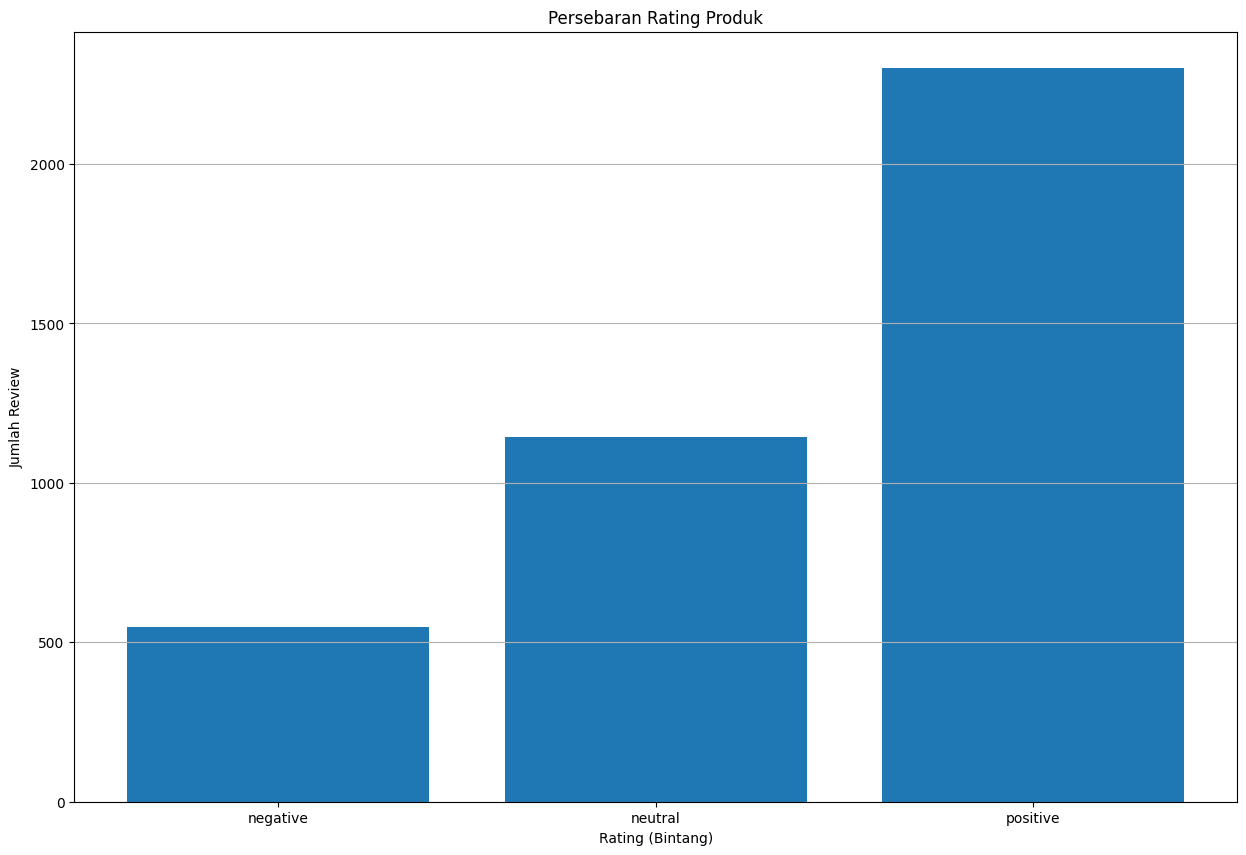

In [6]:
rating_counts = df['sentiment'].value_counts().sort_index()

plt.figure(figsize=(15, 10))
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.title("Persebaran Rating Produk")
plt.xlabel("Rating (Bintang)")
plt.ylabel("Jumlah Review")
plt.grid(True, axis='y')
plt.show()

In [7]:
df['text_length'] = df['review'].apply(lambda x: len(str(x).split()))
df['text_length'].describe()

count    3992.000000
mean       12.227204
std        16.085300
min         1.000000
25%         4.000000
50%         8.000000
75%        15.000000
max       531.000000
Name: text_length, dtype: float64

## Hapus Outlier

In [8]:
# Hitung Q1, Q3, dan IQR
Q1 = df["text_length"].quantile(0.25)
Q3 = df["text_length"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Hapus outlier
df = df[df["text_length"] <= upper_bound].copy()

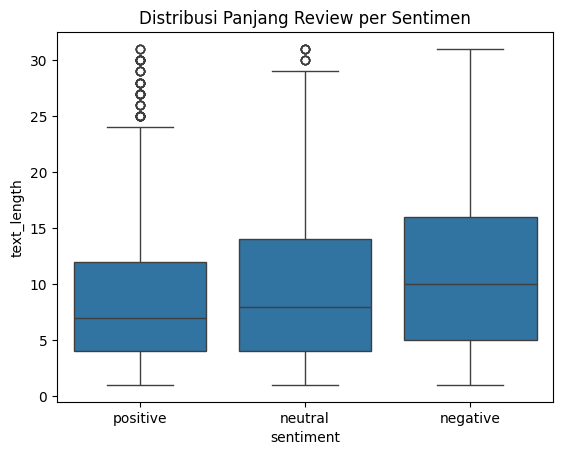

In [9]:
sns.boxplot(x='sentiment', y='text_length', data=df)
plt.title('Distribusi Panjang Review per Sentimen')
plt.show()

<Axes: xlabel='rating'>

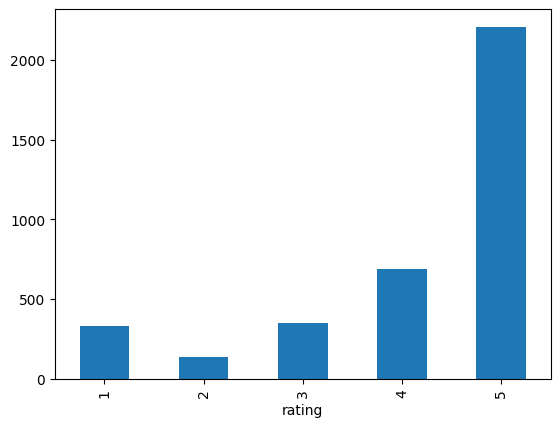

In [10]:
df['rating'].value_counts().sort_index().plot(kind='bar')

In [11]:
df['timestamp'].value_counts().head(10)

timestamp
Lebih dari 1 tahun lalu    1985
6 bulan lalu                181
2 bulan lalu                173
3 bulan lalu                167
1 bulan lalu                167
5 bulan lalu                166
7 bulan lalu                152
9 bulan lalu                132
4 bulan lalu                116
8 bulan lalu                115
Name: count, dtype: int64

## Word Cloud

In [12]:
# Fungsi untuk membersihkan teks
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # lowercase + hapus simbol
    return text

# Fungsi untuk generate word cloud dari teks tertentu
def generate_wordcloud(text, title="WordCloud"):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          max_words=100,
                          colormap='viridis').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

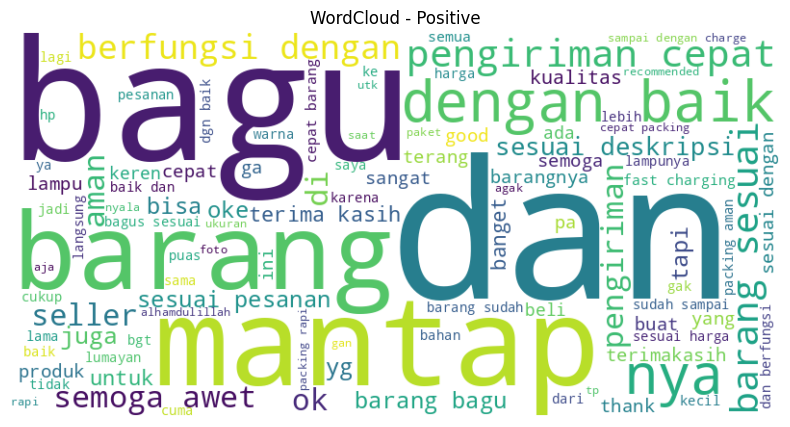

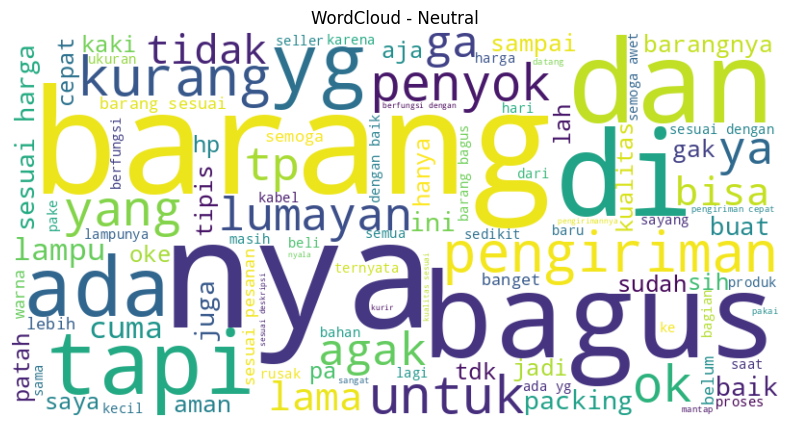

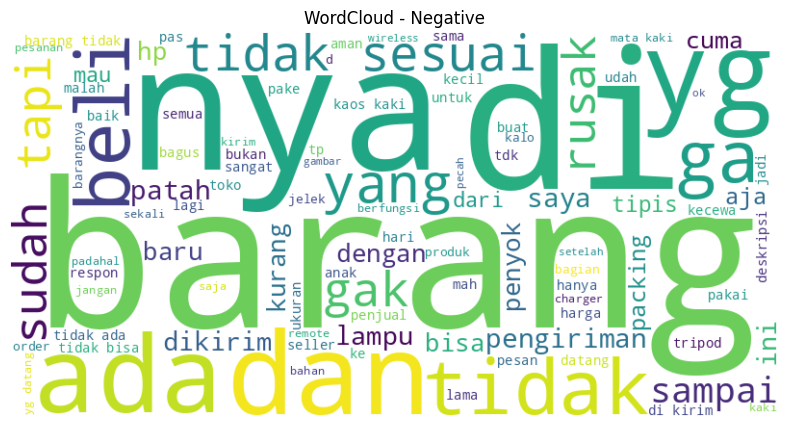

In [13]:
for sentiment_label in df['sentiment'].unique():
    subset = df[df['sentiment'] == sentiment_label]
    combined_text = " ".join(subset['review'].astype(str).tolist())
    cleaned = clean_text(combined_text)
    generate_wordcloud(cleaned, title=f"WordCloud - {sentiment_label.capitalize()}")

# Preprocessing

## Normalize & Stemming

In [14]:
# Inisialisasi stopword dan stemmer
stop_factory = StopWordRemoverFactory()
stopwords = set(stop_factory.get_stop_words())

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Kamus normalisasi kata gaul → baku (tambahkan sesuai kebutuhan)
normalization_dict = {
    "gk": "tidak",
    "ga": "tidak",
    "g": "tidak",
    "tdk": "tidak",
    "nggak": "tidak",
    "ngga": "tidak",
    "bgt": "banget",
    "bgd": "banget",
    "bgtu": "begitu",
    "dgn": "dengan",
    "udh": "sudah",
    "sdh": "sudah",
    "blm": "belum",
    "dr": "dari",
    "sm": "sama",
    "tp": "tapi",
    "aja": "saja",
    "yg": "yang",
    "krn": "karena",
    "kmrn": "kemarin",
    "trs": "terus",
    "udh": "sudah",
    "blg": "bilang",
    "beliin": "belikan",
    "bgt": "banget",
}

In [15]:
def normalize_text(text):
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

def clean_review(text, do_stemming=True):
    # Lowercase
    text = text.lower()

    # Hapus simbol, angka, emoji, tanda baca
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Normalisasi kata
    text = normalize_text(text)

    # Hapus stopwords
    tokens = [word for word in text.split() if word not in stopwords]

    # Stemming (opsional)
    if do_stemming:
        text = " ".join([stemmer.stem(word) for word in tokens])
    else:
        text = " ".join(tokens)

    return text

In [16]:
df["cleaned_review"] = df["review"].apply(clean_review)

## Labeling

In [17]:
X = df["cleaned_review"].astype(str)
y = df["sentiment"].map({"negative": 0, "neutral": 1, "positive": 2})

## Split Data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## TF-IDF Vectorization

In [19]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Modeling

## SVM

In [20]:
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_vec, y_train)
y_pred_svm = svm_model.predict(X_test_vec)

## Random Forest

In [21]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vec, y_train)
y_pred_rf = rf_model.predict(X_test_vec)

# Evaluasi

In [22]:
# Fungsi evaluasi
def evaluate_model(name, y_true, y_pred):
    print(f"\n🔎 Evaluasi Model: {name}")
    print(classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"]))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["negative", "neutral", "positive"],
                yticklabels=["negative", "neutral", "positive"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


🔎 Evaluasi Model: SVM (TF-IDF)
              precision    recall  f1-score   support

    negative       0.53      0.35      0.42       141
     neutral       0.58      0.47      0.52       312
    positive       0.78      0.91      0.84       663

    accuracy                           0.71      1116
   macro avg       0.63      0.58      0.59      1116
weighted avg       0.69      0.71      0.70      1116



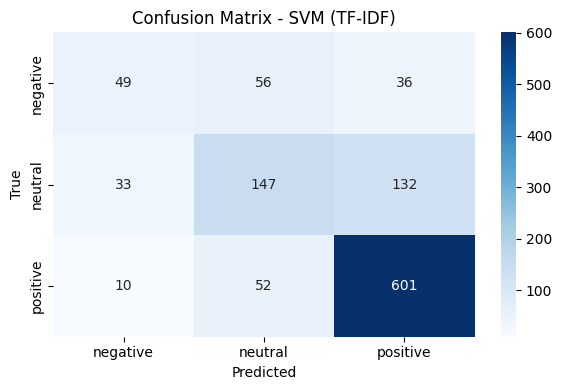

In [23]:
evaluate_model("SVM (TF-IDF)", y_test, y_pred_svm)


🔎 Evaluasi Model: Random Forest (TF-IDF)
              precision    recall  f1-score   support

    negative       0.65      0.22      0.33       141
     neutral       0.58      0.50      0.54       312
    positive       0.75      0.91      0.82       663

    accuracy                           0.71      1116
   macro avg       0.66      0.54      0.56      1116
weighted avg       0.69      0.71      0.68      1116



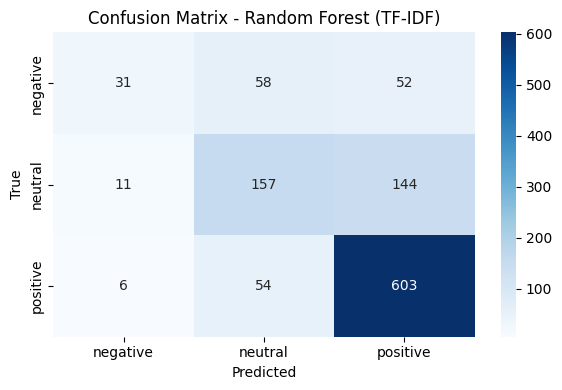

In [24]:
evaluate_model("Random Forest (TF-IDF)", y_test, y_pred_rf)

# Testing

In [30]:
label_map = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

def predict_sentiment_svm(text):
    cleaned = preprocess(text)
    vector = vectorizer.transform([cleaned])
    pred = svm_model.predict(vector)[0]
    return label_map[pred]

def predict_sentiment_rf(text):
    cleaned = preprocess(text)
    vector = vectorizer.transform([cleaned])
    pred = rf_model.predict(vector)[0]
    return label_map[pred]

In [34]:
examples = [
    "Barang sampai dalam kondisi kotor dan lecet",
    "Sudah nunggu lama tapi barang belum juga dikirim",
    "Kualitas sangat buruk, tidak layak pakai",
    "Respon penjual lambat dan tidak membantu",
    "Ukuran tidak sesuai dengan yang tertera di deskripsi",
    "Pengiriman tepat waktu, produk sesuai gambar",
    "Baru datang hari ini, belum bisa kasih penilaian lengkap",
    "Harga sesuai, kualitas standar",
    "Barang sesuai deskripsi, tidak ada yang istimewa",
    "Sudah dipakai seminggu, belum ada masalah",
    "Sangat puas dengan belanja kali ini!",
    "Produk premium dengan harga terjangkau, mantap!",
    "Fast delivery dan barang original, keren banget",
    "Semua berfungsi dengan baik, sesuai harapan",
    "Toko terpercaya, pelayanan top, akan beli lagi"
]

for i, example in enumerate(examples, start=1):
    result_svm = predict_sentiment_svm(example)
    result_rf = predict_sentiment_rf(example)
    print(f"Example {i}:")
    print(f"  SVM Prediction: {result_svm}")
    print(f"  RF  Prediction: {result_rf}")
    print(f"  Review         : {example}")
    print("-" * 60)


Example 1:
  SVM Prediction: neutral
  RF  Prediction: positive
  Review         : Barang sampai dalam kondisi kotor dan lecet
------------------------------------------------------------
Example 2:
  SVM Prediction: positive
  RF  Prediction: positive
  Review         : Sudah nunggu lama tapi barang belum juga dikirim
------------------------------------------------------------
Example 3:
  SVM Prediction: negative
  RF  Prediction: negative
  Review         : Kualitas sangat buruk, tidak layak pakai
------------------------------------------------------------
Example 4:
  SVM Prediction: neutral
  RF  Prediction: neutral
  Review         : Respon penjual lambat dan tidak membantu
------------------------------------------------------------
Example 5:
  SVM Prediction: positive
  RF  Prediction: positive
  Review         : Ukuran tidak sesuai dengan yang tertera di deskripsi
------------------------------------------------------------
Example 6:
  SVM Prediction: positive
  RF  Predic